<a href="https://colab.research.google.com/github/zeliky/deep-learning-fp/blob/main/final_project_bonus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from scipy.io import loadmat
import numpy as np
from PIL import Image,ImageShow
import matplotlib.pyplot as plt
import re
import os
import math
import random
import tensorflow as tf
import cv2
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Lambda, Flatten, Dense, Dropout,Activation, BatchNormalization,Add, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from keras.regularizers import l2
from keras.callbacks  import Callback
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.metrics import Mean
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras import backend as K
import gc,pickle

In [ ]:
!pip freeze

In [6]:
drive.mount('/gdrive')


Mounted at /gdrive


In [2]:
BASE_PATH  = '/gdrive/MyDrive/deep-learning/final-project/data-sets/'
ORIGINAL_IMAGES = BASE_PATH + "0_Images/"
ROTATED_IMAGES = BASE_PATH + "1_ImagesRotated/"
MEDIAN_BW_IMAGES = BASE_PATH + "2_ImagesMedianBW/"
LINES_REMOVED_BW_IMAGES = BASE_PATH + "3_ImagesLinesRemovedBW/"
LINES_REMOVED_IMAGES = BASE_PATH + "4_ImagesLinesRemoved/"
DARK_LINES = BASE_PATH + "5_DataDarkLines/"
SAMPLE_FILE_PATTERN = "lines{}_Page_{}.jpg"
METADATA_PATTERN = "lines{}_Page_{}.mat"
MODEL_CHECKPOINT_PATH = BASE_PATH + "model_checkpoints/"
SUB_IMAGES_PATH = BASE_PATH + "sub_images/"

ALLOWED_TYPES = [ORIGINAL_IMAGES, ROTATED_IMAGES, MEDIAN_BW_IMAGES, LINES_REMOVED_BW_IMAGES, LINES_REMOVED_IMAGES]
TRAIN_TYPES = [ROTATED_IMAGES,  LINES_REMOVED_BW_IMAGES]
VALIDATE_TYPES = [ORIGINAL_IMAGES]
EMBEDDING_TYPES = [ORIGINAL_IMAGES, LINES_REMOVED_BW_IMAGES]
CLASSIFICATION_TYPES = [ORIGINAL_IMAGES, LINES_REMOVED_BW_IMAGES, LINES_REMOVED_IMAGES]
LINE_SHAPE = (225, 4965)


MODE_TRAIN = 'train'
MODE_VALIDATION = 'validation'
MODE_TEST = 'test'


In [3]:
class MetaData:
  @staticmethod
  def from_mat_data(data):
    metadata = MetaData()
    SCALE_FACTOR = data['SCALE_FACTOR'].flatten()[0]
    peaks_indices = data['peaks_indices'].flatten()
    metadata.min_y  = SCALE_FACTOR * min(peaks_indices)
    metadata.max_y  = SCALE_FACTOR *  max(peaks_indices)
    metadata.peaks_indices = [SCALE_FACTOR*a - metadata.min_y for a in  peaks_indices]
    metadata.index_of_max_in_peak_indices = data['index_of_max_in_peak_indices'].flatten()[0]
    metadata.delta = data['delta'].flatten()[0]
    metadata.top_test_area = data['top_test_area'].flatten()[0] - metadata.min_y
    metadata.bottom_test_area = data['bottom_test_area'].flatten()[0] - metadata.min_y
    metadata.total_lines = len(metadata.peaks_indices)
    return metadata

  def __repr__(self):
    return str(self.__dict__)


In [4]:
class ModelOptions:
    def __init__(self, **kwargs):
        self.num_classes = kwargs.get('num_classes', 200)
        self.batch_size = kwargs.get('batch_size', 100)
        self.image_height = kwargs.get('image_height', 150)
        self.image_width = kwargs.get('image_width', 150)
        self.num_channels = kwargs.get('num_channels', 1)
        self.max_sequence_length = kwargs.get('max_sequence_length', 30)
        self.random_shuffle_amount = kwargs.get('random_shuffle_amount', 1)
        #self.lstm_units = kwargs.get('lstm_units', 5)
        self.max_embedding_samples = kwargs.get('max_embedding_samples', 5)
        self.alpha = kwargs.get('alpha', 0.2)
        self.embedding_dim = kwargs.get('embedding_dim', 64)

    def __repr__(self):
        return str(self.__dict__)
model_options = ModelOptions()


In [7]:
class DataSet:
    def __init__(self):
        self.user_files = {}
        self.metadata = {}
        self._build_index()
        self.reset()

    def reset(self):
        self.images = {}

    def load_image(self, path, user_id, enable_cache=True):
        bin, id = self.user_files[user_id]
        image_type = self._image_type(path)

        file_name = SAMPLE_FILE_PATTERN.format(bin, id)
        image_path = "{}{}".format(path, file_name)
        image_metadata = self._get_cached_metadata(user_id)
        if image_metadata is None:
            image_metadata = self.image_metadata(user_id)
            self._cache_metadata(user_id, image_metadata)

        user_file = self._get_cached_image(image_type, user_id)
        if user_file is None:
            print('loading image from {}'.format(image_path))
            with open(image_path, 'r') as f:
                im = Image.open(image_path)
                user_file = UserFile(im, image_metadata)
                if enable_cache:
                  self._cache_image(image_type, user_id, user_file)
                del im
        return user_file

    def get_testing_strip(self,user_id):
        lines_removed_file = self.load_image(LINES_REMOVED_BW_IMAGES, user_id, enable_cache=False)
        original_user_file = self.load_image(ORIGINAL_IMAGES, user_id, enable_cache=False)
        line = normalized_line(lines_removed_file.get_testing_line())

        binary = np.where(line > 30, 1, 0).astype('uint8')
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
        dilation = cv2.dilate(binary, rect_kernel, iterations=1)
        contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        split_points = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > 10:
                sub_img = line[:, x:x + w]
                # print(f"_get_characters_split_points line \t {idx}\t{x}\t{x+w}\t{sub_img.sum()}")
                if sub_img.sum() > (500 * 255):
                    split_points.append((x-5, y, w+5, h))
        line_org = normalized_line(original_user_file.get_testing_line())
        return user_id,line_org, split_points


    def image_metadata(self, user_id):
        bin, id = self.user_files[user_id]
        file_name = METADATA_PATTERN.format(bin, id)
        metadata_path = "{}{}".format(DARK_LINES, file_name)
        # print(metadata_path)
        data = loadmat(metadata_path)
        return MetaData.from_mat_data(data)

    def _image_type(self, path):
        reg = re.search(r'\d+', path)
        return int(reg.group())


    def _build_index(self):
        directory_files = os.listdir(ORIGINAL_IMAGES)
        for idx, fname in enumerate(directory_files):
            pattern = re.search(r'lines(\d+)_Page_(\d+)', fname.replace(BASE_PATH, ''))
            self.user_files[idx] = (pattern.group(1), pattern.group(2))

    def _get_cached_image(self, image_type, user_id):
        if image_type in self.images and user_id in self.images[image_type]:
            return self.images[image_type][user_id]
        return None

    def _cache_image(self, image_type, user_id, image):
        if image_type not in self.images:
            self.images[image_type] = {}
        if user_id not in self.images[image_type]:
            self.images[image_type][user_id] = image

    def _get_cached_metadata(self, user_id):
        if user_id in self.metadata:
            return self.metadata[user_id]
        return None

    def _cache_metadata(self, user_id, metadata: MetaData):
        self.metadata[user_id] = metadata


# -------------------------------------------------------------------------------
#should be kept global so it will be shared by multi processes
full_data_set = DataSet()

In [ ]:
full_data_set.user_files

In [8]:
class UserFile:
    def __init__(self, im, metadata):
        # image_arr = np.asarray(im.getchannel(0).getdata())

        if im.mode != 'L':
            im = im.convert(mode='L')
        image_arr = np.asarray(im.getchannel(0))
        # image_arr = image_arr.reshape(im.height, im.width)
        # print(image_arr.shape)
        self.data = image_arr[metadata.min_y: metadata.max_y, :]
        self.metadata = metadata

    def get_testing_line(self):
        y_range = (self.metadata.top_test_area, self.metadata.bottom_test_area)
        return self.data[y_range[0]:y_range[1], :]

    def get_test_line_idx(self):
        #print(f"get_test_line_idx metadata{self.metadata}" )
        for i in range(1, self.metadata.total_lines):
            if self.is_test_line(i):
                return i

    def get_all_lines(self, threshold=2000):
        for i in range(1, self.metadata.total_lines):
            yield self.get_line(i)

    def get_line(self, line_idx):
        y_range = (self.metadata.peaks_indices[line_idx - 1:line_idx + 1])
        return self.data[y_range[0]:y_range[1] + 30, :]

    def is_test_line(self, line_idx):
        bounderies = self.metadata.peaks_indices[line_idx - 1:line_idx + 1]
        return abs(int(bounderies[0]) - self.metadata.top_test_area) < 50 and abs(
            int(bounderies[1]) - self.metadata.bottom_test_area) < 50

    def show(self):
        image = Image.fromarray(self.data.astype(np.uint8))
        image.show()


In [9]:
class UserDataset:
    ftypes = {'original': ORIGINAL_IMAGES,
              'rotated':ROTATED_IMAGES,
              'lines_removed_bw':LINES_REMOVED_BW_IMAGES,
              'lines_removed':LINES_REMOVED_IMAGES
              }
    def __init__(self, user_id):
        self.user_id = user_id
        self.train_lines = []
        self.validation_lines = []
        self.all_lines = []
        self.normalized_lines = {}
        self.test_line = None
        self.split_points = {}
        self.min_width = 10
        self.min_colored_pixels = 500 * 255

    def warmup(self, load_types, train_split=0.8, shuffle=True):
        e = ThreadPoolExecutor(max_workers=5) #len(load_types)
        futures = [e.submit(full_data_set.load_image, t, self.user_id) for t in load_types]
        results = [f.result() for f in futures]
        self.split_dataset(train_split, shuffle)

    def split_dataset(self, train_split, shuffle):
        bw_image = full_data_set.load_image(LINES_REMOVED_BW_IMAGES, self.user_id)
        self.train_lines, self.validation_lines = select_train_validation_lines(bw_image, train_split, shuffle)
        self.test_line = bw_image.get_test_line_idx()
        self.all_lines = sorted(self.train_lines + self.validation_lines)

    def get_letters(self, img_path, line_idx, target_size):
        split_points = self._get_characters_split_points(line_idx)
        line = self._get_normalized_line(img_path, line_idx)
        for (x, y, w, h) in split_points:
            img = line[:, x:x + w]
            # print(f"get_letter shape {img.shape}")
            thumbnail = create_thumbnail(img, target_size)
            np_im = np.array(thumbnail, dtype=np.float32) / 255
            np_img = np_im.reshape(target_size[0], target_size[1], 1)
            yield np_img
        return

    def count_possible_options(self, mode):
        total = 0
        lines = self._get_lines_ids_set(mode)
        for line_idx in lines:
            total += len(self._get_characters_split_points(line_idx))-1
        return total

    def count_possible_lines(self, mode):
        return len(self._get_lines_ids_set(mode))


    def sub_images_base_path(self,ftype, line ):
      path = f"{SUB_IMAGES_PATH}{self.user_id}/{ftype}/{line}/"
      if not os.path.exists(path):
        os.makedirs(path)
        print(f"create {path}")
      return path


    def store_sub_lines(self, target_size):
        self.warmup(self.ftypes.values(), train_split=1, shuffle = False)
        index = {}
        for ftype, img_path in self.ftypes.items():
          print(ftype)
          print(img_path)
          for line_idx in self.all_lines:
            index[line_idx] = {}
            base_dir = self.sub_images_base_path(ftype, line_idx)
            line = self._get_normalized_line(img_path, line_idx)
            split_points = self._get_characters_split_points(line_idx)
            for ch_id, (x, y, w, h) in enumerate(split_points):
               index[line_idx][ch_id] = True
               img_array = line[:, x:x + w]
               img = Image.fromarray(img_array)
               store_path = f'{base_dir}{ch_id}.jpg'
               print(store_path)
               img.save(store_path)



        index_path = f"{SUB_IMAGES_PATH}{self.user_id}/index"
        with open(index_path, 'wb') as handle:
          pickle.dump(index, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def get_line_as_sequence(self, img_path, line_idx, max_sequence_length, target_size):
        sequence = []
        line = self._get_normalized_line(img_path, line_idx)
        split_points = self._get_characters_split_points(line_idx)
        for (x, y, w, h) in split_points:
            img = line[:, x:x + w]
            thumbnail = create_thumbnail(img, target_size)
            np_im = np.array(thumbnail, dtype=np.float32) / 255
            np_img = np_im.reshape(target_size[0], target_size[1], 1)
            sequence.append(np_img)
        return pad_sequence(max_sequence_length, sequence, target_size[0], target_size[1], 1)

    def valid_line_generator(self, mode, max_sequence_length, target_size, allowed_types=ALLOWED_TYPES):
        #print(f'valid_line_generator start')
        img_path = random.choice(allowed_types)
        lines = self._get_lines_ids_set(mode)
        print(f'valid_line_generator: user {self.user_id} line: {lines}')
        for line_idx in lines:
            line = self._get_normalized_line(img_path, line_idx)
            split_points = self._get_characters_split_points(line_idx)
            sequence = []
            if len(split_points) ==0:
                  print(f"no split points for user {self.user_id} line:{line_idx}")
                  continue
            seq_len = 0
            for (x, y, w, h) in split_points:
                if seq_len == max_sequence_length:
                  #print(f"line is longer than  {max_sequence_length} line:{line_idx}")
                  break
                img = line[:, x:x + w]
                thumbnail = create_thumbnail(img, target_size, data_augmentation=False)
                np_im = np.array(thumbnail, dtype=np.float32) / 255
                np_img = np_im.reshape(target_size[0], target_size[1], 1)
                sequence.append(np_img)
                seq_len += 1
            #print(f"pad_sequence  for sequence len:{len(sequence)}")
            yield pad_sequence(max_sequence_length, sequence, target_size[0], target_size[1], 1)

    def random_line_generator(self, mode, max_sequence_length, target_size, allowed_types=ALLOWED_TYPES):
        while True:
            #print(f"random_line_generator types: {allowed_types}")
            img_path = random.choice(allowed_types)
            lines = self._get_lines_ids_set(mode)

            sequence_length = random.randint(int(0.7 * max_sequence_length), max_sequence_length)
            #print(f"random_line_generator sequence_length: {sequence_length}")
            sequence = []
            for _ in range(sequence_length):
                line_idx = random.choice(lines)
                #print(f"random_line_generator line_idx: {line_idx}")
                line = self._get_normalized_line(img_path, line_idx)
                split_points = self._get_characters_split_points(line_idx)
                if len(split_points) ==0:
                  #print(f"no split points for user {self.user_id} line:{line_idx}")
                  continue
                (x, y, w, h) = random.choice(split_points)
                #print(f"random_line_generator split_points: {x}")
                img = line[:, x:x + w]
                thumbnail = create_thumbnail(img, target_size)
                np_im = np.array(thumbnail, dtype=np.float32) / 255
                np_img = np_im.reshape(target_size[0], target_size[1], 1)
                sequence.append(np_img)
            yield pad_sequence(max_sequence_length, sequence, target_size[0], target_size[1], 1)

    def valid_letters_generator(self, mode, target_size, allowed_types=ALLOWED_TYPES):
        lines = self._get_lines_ids_set(mode)
        for line_idx in lines:
            for img_path in allowed_types:
                line = self._get_normalized_line(img_path, line_idx)
                split_points = self._get_characters_split_points(line_idx)
                points_amount = len(split_points)

                for split_index in range(0, points_amount - 1):
                    (x, y, w, h) = split_points[split_index]
                    img = line[:, x:x + w]
                    thumbnail = create_thumbnail(img, target_size, data_augmentation=False)
                    np_im = np.array(thumbnail, dtype=np.float32) / 255
                    np_img = np_im.reshape(target_size[0], target_size[1], 1)
                    #print(f"{img_path}: u:{self.user_id} l:{line_idx} x:{x}-{x+w}")
                    yield np_img, img_path, line_idx, split_index

    def random_letters_generator(self, mode, target_size, random_shuffle_amount=1, allowed_types=ALLOWED_TYPES):
        while True:
            img_path = random.choice(allowed_types)
            lines = self._get_lines_ids_set(mode)
            line_idx = random.choice(lines)
            line = self._get_normalized_line(img_path, line_idx)
            split_points = self._get_characters_split_points(line_idx)
            points_amount = len(split_points)
            if points_amount <= 2:  # skip lines with too few examples
                continue
            split_index = random.randint(0, points_amount - 1)
            (x, y, w, h) = split_points[split_index]

            img = line[:, x:x + w]
            thumbnails = [create_thumbnail(img, target_size) for _ in range(random_shuffle_amount)]
            for i, thumbnail in enumerate(thumbnails):
                np_im = np.array(thumbnail, dtype=np.float32) / 255
                np_img = np_im.reshape(target_size[0], target_size[1], 1)
                # print(f"{img_path}: u:{self.user_id} l:{line_idx} x:{x}-{x+w} rand:{i}")
                yield np_img, img_path, line_idx, split_index

    def get_letter(self, img_path, line_idx, split_index, target_size):
        line = self._get_normalized_line(img_path, line_idx)
        split_points = self._get_characters_split_points(line_idx)
        (x, y, w, h) = split_points[split_index]
        img = line[:, x:x + w]
        thumbnail = create_thumbnail(img, target_size)
        np_im = np.array(thumbnail, dtype=np.float32) / 255
        return np_im.reshape(target_size[0], target_size[1], 1)

    def _get_lines_ids_set(self, mode):
        if mode == MODE_TRAIN:
            return self.train_lines
        elif mode == MODE_VALIDATION:
            return self.validation_lines
        return [self.test_line]

    def _get_characters_split_points(self, idx):
        if idx in self.split_points:
            return self.split_points[idx]
        line = self._get_normalized_line(LINES_REMOVED_BW_IMAGES, idx)
        binary = np.where(line > 30, 1, 0).astype('uint8')
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
        dilation = cv2.dilate(binary, rect_kernel, iterations=1)
        contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        split_points = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > self.min_width:
                sub_img = line[:, x:x + w]
                # print(f"_get_characters_split_points line \t {idx}\t{x}\t{x+w}\t{sub_img.sum()}")
                if sub_img.sum() > self.min_colored_pixels:
                    split_points.append((x-5, y, w+5, h))

        self.split_points[idx] = sorted(split_points, key=lambda tup: tup[0])
        # print( self.split_points[idx])
        return self.split_points[idx]

    def _get_normalized_line(self, img_path, line_idx):
        if img_path not in self.normalized_lines:
            self.normalized_lines[img_path] = {}
        if line_idx not in self.normalized_lines:
            user_file = full_data_set.load_image(img_path, self.user_id)
            self.normalized_lines[img_path][line_idx] = normalized_line(user_file.get_line(line_idx))
        return self.normalized_lines[img_path][line_idx]




In [10]:
def image_dots(img_data, threshold=50):
    height, width = img_data.shape
    for i in range(height):
        line = ''
        for j in range(width):
            if img_data[i, j] < threshold:
                line += ' '
            else:
                line += '.'
        print(line)


def show_line(line_data):
    plt.clf()
    plt.figure(figsize=(20, 5))
    plt.axis('off')
    plt.imshow(line_data.astype(np.uint8), cmap='gray')
    plt.show()



def is_empty_line(line_data, threshold=5000):
    values = line_data.flatten()
    sum = values[values < 50].sum()
    # print("is_empty_line {}".format(sum))
    return sum < threshold


def normalized_line(line_data):
    desired_shape = LINE_SHAPE
    # normalized_data =  (255 - line_data) / 255.0
    normalized_data = (255 - line_data)
    pad_rows = max(0, desired_shape[0] - normalized_data.shape[0])
    pad_cols = max(0, desired_shape[1] - normalized_data.shape[1])

    padded_array = np.pad(normalized_data, ((0, pad_rows), (0, pad_cols)), mode='constant')
    return padded_array


def select_train_validation_lines(user_image, train_split, shuffle):
    rows = []
    for i, line in enumerate(user_image.get_all_lines()):
        idx = i + 1
        if not user_image.is_test_line(idx) and not is_empty_line(line):
            rows.append(idx)
    if shuffle:
        random.shuffle(rows)
    split_idx = int(len(rows) * train_split)
    # print((rows[0:split_idx], rows[split_idx:]))
    return (rows[0:split_idx], rows[split_idx:])


def split_and_shuffle_array(arr, split_points):
    chunks = split_array(arr, split_points)
    np.random.shuffle(chunks)
    shuffled_array = np.concatenate(chunks, axis=1)
    return shuffled_array


def split_array(arr, split_points):
    chunks = []
    start_idx = 0
    for end_idx in split_points:
        chunk = arr[:, start_idx:end_idx]
        chunks.append(chunk)
        start_idx = end_idx
    last_chunk = arr[:, start_idx:]
    chunks.append(last_chunk)
    return chunks


def create_thumbnail(image_array, target_size, data_augmentation=True):
    height, width = image_array.shape
    target_height, target_width = target_size
    org_image = Image.fromarray(image_array)

    if data_augmentation:
        random_scale_w = random.uniform(0.85, 1.15)
        random_scale_h = random.uniform(0.85, 1.15)
        random_rotate = random.randint(-10, 10)
        org_image_rs = org_image.resize((int(width * random_scale_w), int(height * random_scale_h)), Image.NEAREST)
        org_image_ro = org_image_rs.rotate(random_rotate, Image.NEAREST, expand=True)
    else:
        org_image_ro = org_image

    canvas = Image.new("L", (height, height), 0)
    if width < height:
        left = (height - width) // 2
        top = 0
        canvas.paste(org_image_ro, (left, top))
    else:
        scale_factor = height / width
        s_width = round(scale_factor * width)
        s_height = round(scale_factor * height)
        resized_image = org_image_ro.resize((s_width, s_height), Image.NEAREST)
        left = (height - s_width) // 2
        top = 0
        canvas.paste(resized_image, (left, top))
        del resized_image

    if data_augmentation:
        del org_image_rs
        del org_image_ro
    del org_image

    thumbnail = canvas.resize((target_width, target_height), Image.NEAREST)
    return thumbnail

def show_strip(the_images):
    l = len(the_images)
    plt.clf()
    fig, axs = plt.subplots(1, l, figsize=(15, 25))
    for i in range(0, l ):
        img = the_images[i]
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
    plt.show()


def show_sequence(the_images):
    l = len(the_images)
    dim = math.ceil(math.sqrt(l))
    plt.clf()
    fig, axs = plt.subplots(dim, dim, figsize=(10, 10))
    k = 0
    for i in range(0, dim):
        for j in range(0, dim):
            img = the_images[k]
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
            k += 1
            if k == l:
                plt.show()
                return


def show_triplet(triplets):
    plt.clf()
    fig, axs = plt.subplots(1, 3, figsize=(5, 5))

    for k in range(0, 3):
        img = triplets[k]
        axs[k].imshow(img, cmap='gray')
        axs[k].axis('off')

    plt.show()


def pad_sequence(max_sequence_length, sequence, image_height, image_width, num_channels):
    sequence = np.asarray(sequence)
    padding_size = max_sequence_length - len(sequence)
    if padding_size > 0:
        padding_shape = (padding_size, image_height, image_width, num_channels)
        padding_images = np.zeros(padding_shape)
        padded_sequence = np.concatenate([sequence, padding_images], axis=0)
    else:
        padded_sequence = np.asarray(sequence)
    return padded_sequence


def pad_sequences(max_length, sequences, image_height, image_width, num_channels):
    # Pad sequences to have the same length (pad with zero images)
    padded_sequences = []
    for sequence in sequences:
        seq_len = len(sequence)
        if seq_len == 0:
            continue
        if seq_len > max_length:
            sequence = sequence[:max_length]
            seq_len = len(sequence)

        num_padding = max_length - seq_len
        if num_padding > 0:
            sequence = np.concatenate(
                [sequence, np.zeros((num_padding, image_height, image_width, num_channels))])
        padded_sequences.append(sequence)
    return np.array(padded_sequences)


In [ ]:
class FinalStopIteration(StopIteration):
    def __init__(self, *args: object) -> None:
        super().__init__(*args)


In [11]:
class BaseLetterGenerator(Sequence):
    MAX_USERS_PER_CHUNK = 200

    def __init__(self, mode, user_ids, options: ModelOptions, load_types):
        self.options = options
        self.all_user_ids = [i for i in user_ids]
        self.id_to_class = {user_id: i for i, user_id in enumerate(user_ids)}
        print(f'id_to_class:{self.id_to_class}')
        self.user_ids = []
        self.input_shape = (options.image_height, options.image_width)
        self.random_shuffle_amount = options.random_shuffle_amount
        self.users_ds = {}
        self.generators = {}

        # generator settings.
        self.mode = mode
        self.load_types = load_types
        self.train_split = 0.8
        self.shuffle = True

        self.select_users_chunk()

    def __len__(self):
        return self.options.max_embedding_samples // self.options.batch_size

    def select_users_chunk(self):
        chunk_size = min(len(self.all_user_ids), self.MAX_USERS_PER_CHUNK)
        print(f"select_users_chunk {chunk_size} out of {len(self.all_user_ids)} ")
        self.user_ids = random.sample(self.all_user_ids, chunk_size)
        print(f"selected user_ids {self.user_ids}")

    def on_epoch_end(self):
        global full_data_set
        # full_data_set = DataSet()
        self.select_users_chunk()
        self.generators = {}
        print('running GarbageCollector...')
        gc.collect()

    def reset_generators(self):
        self.generators = {}

    def set_user_ids(self, user_ids):
        print(f"updating user_ids set to {user_ids}")
        self.user_ids = user_ids

    def get_user_ds(self, user_id):
        if user_id not in self.users_ds:
            uds = UserDataset(user_id)
            uds.warmup(self.load_types, self.train_split, self.shuffle)
            self.users_ds[user_id] = uds
        return self.users_ds[user_id]
    def remove_user_ds(self,user_id):
        if user_id in self.users_ds:
            del self.users_ds[user_id]

    def get_letters_generator(self, user_id, is_anchor=False):
        key = f"anc{user_id}" if is_anchor else str(user_id)
        if key not in self.generators:
            # print(f"new generator for {user_id} anchor{is_anchor}")
            uds = self.get_user_ds(user_id)
            if self.mode == MODE_TEST:
                self.generators[key] = uds.valid_letters_generator(mode=self.mode, target_size=self.input_shape,
                                                                   allowed_types=self.load_types)
            else:
                self.generators[key] = uds.random_letters_generator(mode=self.mode, target_size=self.input_shape,
                                                                    allowed_types=self.load_types,
                                                                    random_shuffle_amount=self.random_shuffle_amount)
        return self.generators[key]

    def set_train_split(self, train_split):
        self.train_split = train_split

    def set_shuffle(self, shuffle):
        self.shuffle = shuffle

    def get_allowed_types(self, mode=None):
        if mode is None:
            mode = self.mode

        if mode == MODE_TRAIN:
            allowed_types = TRAIN_TYPES
        elif mode == MODE_TEST or mode == MODE_VALIDATION:
            allowed_types = VALIDATE_TYPES
        else:
            allowed_types = TRAIN_TYPES

        return allowed_types

class LettersGenerator(BaseLetterGenerator):
    def __init__(self, mode, user_ids, options: ModelOptions, total_users):
        allowed_types = self.get_allowed_types(mode)

        super().__init__(mode, user_ids, options, allowed_types)
        self.total_users = total_users

    def __len__(self):
        if self.mode == MODE_TEST or self.mode==MODE_VALIDATION:
            total_batches =  self._exact_len() // self.options.batch_size
        else:
          #lines = 20
          lines = 15
          users = len(self.user_ids)
          #letters_per_line = self.options.max_sequence_length
          letters_per_line =30
          types = len(self.load_types)
          random_shuffle_amount = 5
          total_batches = (types * lines * users * letters_per_line* random_shuffle_amount) // self.options.batch_size
          # print(f"LettersGenerator __len__ {total_batches}")


        return total_batches+1 if total_batches  else 1

    def __getitem__(self, index):
        batch, labels = [], []
        possible_items = self.options.batch_size if self.mode != MODE_TEST else min(self.options.batch_size,
                                                                                    self._exact_len())
        uids = [i for i in self.user_ids]
        for s in range(possible_items):
            if len(uids) == 0:
                break
            user_id = random.choice(uids)
            # print(f"__getitem__{user_id}")
            try:
                letter, _, _, _ = next(self.get_letters_generator(user_id))
                batch.append(letter)
                labels.append(to_categorical(self.id_to_class[user_id], num_classes=self.total_users))
            except StopIteration:
                uids.remove(user_id)

        if len(batch) == 0:
            batch = np.zeros((self.options.batch_size, self.options.image_height, self.options.image_width, 1))
            labels = np.zeros((self.options.batch_size,))
        # print(f"LettersGenerator:{self.mode}__getitem__ batch: {len(batch)},{len(labels)}")
        return np.asarray(batch), np.asarray(labels)

    def _exact_len(self):
        total = 0
        for user_id in self.user_ids:
            uds = self.get_user_ds(user_id)
            total += uds.count_possible_options(self.mode)
        print(total)
        return total


class TripletsGenerator(BaseLetterGenerator):
    def __init__(self, mode, user_ids, options: ModelOptions):
        super().__init__(mode, user_ids, options, EMBEDDING_TYPES)
        self.set_train_split(1)  # it should iterate all rows
        self.set_shuffle(False)

    def __len__(self):
        lines = 20
        users = len(self.user_ids)
        letters_per_line = self.options.max_sequence_length
        random_shuffle_amount = 5

        total_batches = (lines * users * letters_per_line * random_shuffle_amount) // self.options.batch_size
        # print(f"LettersGenerator __len__ {total_batches}")
        return total_batches

    def __getitem__(self, index):
        anchors, positives, negatives = [], [], []
        for _ in range(self.options.batch_size):
            # print(f"__getitem__ {2} out of {len(self.user_ids)} ")
            positive_user, negative_user_id = random.sample(self.user_ids, 2)
            # print(f"TripletsGenerator __getitem__ {positive_user} {negative_user_id} " )
            for triplet in self.get_triplets(positive_user, negative_user_id):
                if triplet is None:
                    # print(f"__getitem__ {2} out of {len(self.user_ids)} ")
                    positive_user, negative_user_id = random.sample(self.user_ids, 2)
                    continue
                anchor, positive, negative = triplet
                anchors.append(anchor)
                positives.append(positive)
                negatives.append(negative)

        batch = [np.asarray(anchors), np.asarray(positives), np.asarray(negatives)]
        return batch, []

    def get_triplets(self, positive_user, negative_user_id):
        anc_letter, img_path, line_idx, split_index = next(self.get_letters_generator(positive_user, True))
        uds = self.get_user_ds(positive_user)
        filtered = list(filter(lambda im_type: im_type != img_path, self.load_types))
        if len(filtered) > 0:
            img_path = random.choice(filtered)
        positive_letter = uds.get_letter(img_path, line_idx, split_index, self.input_shape)
        negative_letter, _, _, _ = next(self.get_letters_generator(negative_user_id, False))
        if anc_letter is not None and positive_letter is not None and negative_letter is not None:
            yield anc_letter, positive_letter, negative_letter


class SequenceGenerator(BaseLetterGenerator):
    def __init__(self, mode, user_ids, options: ModelOptions):
        allowed_types = self.get_allowed_types(mode)
        super().__init__(mode, user_ids, options, allowed_types)
        self.set_train_split(0.90)
        self.set_shuffle(True)

    def on_epoch_end(self):
        self.reset_generators()

    def get_sequence_generator(self, user_id):
        if user_id not in self.generators:
            # print(f"new generator for {user_id}")
            uds = self.get_user_ds(user_id)
            if self.mode != MODE_TEST:
                self.generators[user_id] = uds.random_line_generator(mode=self.mode,
                                                                     max_sequence_length=self.options.max_sequence_length,
                                                                     target_size=self.input_shape,
                                                                     allowed_types=self.load_types)
            else:
                # replace to valid_line_generator
                self.generators[user_id] = uds.valid_line_generator(mode=self.mode,
                                                                    max_sequence_length=self.options.max_sequence_length,
                                                                    target_size=self.input_shape,
                                                                    allowed_types=self.load_types)
        return self.generators[user_id]

    def __len__(self):
        if self.mode == MODE_TEST:
            total_batches = self._exact_len() // self.options.batch_size
        else:
            lines = 20
            users = len(self.user_ids)
            random_shuffle_amount = self.options.random_shuffle_amount
            types = len(ALLOWED_TYPES)
            total_batches = (types * lines * users * random_shuffle_amount) // self.options.batch_size
        return total_batches + 1 if total_batches else 1

    def __getitem__(self, index):
        batch, labels = [], []
        possible_items = self.options.batch_size if self.mode != MODE_TEST else min(self.options.batch_size,
                                                                                    self._exact_len())
        uids = [i for i in self.user_ids]
        for s in range(possible_items):
            if len(uids) == 0:
                break
            user_id = random.choice(uids)
            try:
                sequence = next(self.get_sequence_generator(user_id))
                batch.append(sequence)
                labels.append(to_categorical(self.id_to_class[user_id], num_classes=self.options.num_classes))
            except StopIteration:
                uids.remove(user_id)
                self.remove_user_ds(user_id)
        return np.asarray(batch), np.asarray(labels)

    def _exact_len(self):
        total = 0
        for user_id in self.user_ids:
            uds = self.get_user_ds(user_id)
            total += uds.count_possible_lines(self.mode)
        return total


Display generators

# **CNN one letter classification**

In [12]:
class OneLetterClassifierModel:

    def get_model(self, input_shape, num_classes):
        model = Sequential()
        model.add(Input(shape=input_shape))
        # Convolutional layers
        model.add(Conv2D(input_shape=input_shape,
                         filters=8, kernel_size=(3, 3), padding='SAME', activation='relu', name='conv2d-1'))
        model.add(MaxPooling2D((3, 3)))

        model.add(Conv2D(filters=128, kernel_size=(6, 6), padding='SAME', activation='relu', name='conv2d-2'))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(filters=256, kernel_size=(4, 4), padding='SAME', activation='relu', name='conv2d-3'))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu', name='conv2d-4'))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu', name='conv2d-5'))
        model.add(MaxPooling2D((2, 2), name='last-maxpooling'))

        model.add(Flatten(name='last-flatten'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', name='dense_512'))
        model.add(Dropout(0.2))
        model.add(Dense(num_classes, activation='softmax'))
        return model

### **Sequence Model - uses on letter classifier with GRU + Attention**

In [13]:
from tensorflow.keras.layers import Bidirectional, GRU, Attention, Dot, Multiply, Input, MaxPooling2D, Conv2D, Flatten, Dense, TimeDistributed
from tensorflow.keras.models import Sequential, load_model, Model

class SequenceClassificationModel:


    def get_model(self, options: ModelOptions, letter_classifier, slice_layer):
        input_shape = (options.image_height, options.image_width, 1)

        # Create a new model based on OneLetterClassifierModel architecture
        sequence_input = Input(shape=(options.max_sequence_length,) + input_shape)

        # Slice the letter classifier model up to the specified layer
        letter_classifier = Model(inputs=letter_classifier.input, outputs=letter_classifier.get_layer(slice_layer).output)

        letter_classifier_timesteps = TimeDistributed(letter_classifier)(sequence_input)
        #x = TimeDistributed(Flatten())(letter_classifier_timesteps)
        x = TimeDistributed(Dense(400, activation='relu'))(letter_classifier_timesteps)


        # Apply Bidirectional GRU
        bidir_gru = Bidirectional(GRU(400, return_sequences=True, dropout=0.2), merge_mode='sum')(x)

        # Apply Attention mechanism
        context_vector = Attention()([x, bidir_gru])  # Using bidir_gru as values


        # Flatten and apply a dense layer to produce the classification output
        flattened_context = Flatten()(context_vector)
        #x= Dropout(0.2)(flattened_context)
        #x = Dense(512, activation='softmax')(flattened_context)
        #x=Dropout(0.2)(x)
        sequence_output = Dense(options.num_classes, activation='softmax')(flattened_context)


        # Create the final sequence classification model
        final_model = Model(inputs=sequence_input, outputs=sequence_output)

        return final_model




### continue training

In [17]:
 gc.collect()

18

In [16]:
filepath = MODEL_CHECKPOINT_PATH + "sequence-classifier-model-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, mode='min')
callbacks_list = [checkpoint]

model_options.max_sequence_length = 30
model_options.batch_size = 10
model = load_model(MODEL_CHECKPOINT_PATH+'sequence-classifier-model-08-0.47.hdf5')
user_ids = range(204,254)
train_gen = SequenceGenerator(MODE_TRAIN, user_ids, model_options)
num_epochs = 8


opt =  Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_gen, epochs=num_epochs, batch_size=model_options.batch_size,
                    verbose=1, callbacks=callbacks_list)


id_to_class:{204: 0, 205: 1, 206: 2, 207: 3, 208: 4, 209: 5, 210: 6, 211: 7, 212: 8, 213: 9, 214: 10, 215: 11, 216: 12, 217: 13, 218: 14, 219: 15, 220: 16, 221: 17, 222: 18, 223: 19, 224: 20, 225: 21, 226: 22, 227: 23, 228: 24, 229: 25, 230: 26, 231: 27, 232: 28, 233: 29, 234: 30, 235: 31, 236: 32, 237: 33, 238: 34, 239: 35, 240: 36, 241: 37, 242: 38, 243: 39, 244: 40, 245: 41, 246: 42, 247: 43, 248: 44, 249: 45, 250: 46, 251: 47, 252: 48, 253: 49}
select_users_chunk 50 out of 50 
selected user_ids [225, 222, 245, 229, 236, 239, 217, 215, 223, 250, 204, 208, 232, 230, 206, 207, 226, 234, 238, 221, 231, 233, 218, 241, 249, 211, 214, 252, 246, 212, 240, 253, 209, 216, 224, 228, 251, 243, 227, 235, 244, 242, 213, 220, 248, 247, 210, 237, 219, 205]
Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)       

## **EVALUATE MODEL**

In [17]:
class TesingData:
  def __init__(self):
    self.user_ids = []
    self.testing_data = {}
    self.id_to_class = {}
  def prepare_test_lines(self, user_ids):
    self.user_ids = user_ids

    e = ThreadPoolExecutor(max_workers=10)
    futures = [e.submit(full_data_set.get_testing_strip, user_id) for user_id in self.user_ids]
    results = [f.result() for f in futures]

    testing_data = {}
    for user_id, line, split_points in results:
      self.testing_data[user_id]= {
          'line': line,
          'split_points' : split_points
      }

  def dump_data(self, output_path):
      with open(MODEL_CHECKPOINT_PATH + output_path, 'wb') as f:
        pickle.dump(self.testing_data, f)

  def load_test_lines(self, stored_path):
      with open(MODEL_CHECKPOINT_PATH + stored_path, 'rb') as f:
        self.testing_data = pickle.load(f)

  def line_generator(self, max_sequence_length, target_size):
    img_path = ORIGINAL_IMAGES
    self.id_to_class = {user_id: i for i, user_id in enumerate(self.testing_data.keys())}
    print(self.id_to_class )
    for user_id in self.testing_data:
        line = self.testing_data[user_id]['line']
        split_points = self.testing_data[user_id]['split_points']
        sequence = []
        if len(split_points) == 0:
            print(f"no split points for user {user_id} ")
            continue
        seq_len = 0
        if len(split_points) > max_sequence_length:
          split_points = random.sample(split_points,max_sequence_length )

        for (x, y, w, h) in split_points:
            if seq_len == max_sequence_length:
                yield self.id_to_class[user_id], pad_sequence(max_sequence_length, sequence, target_size[0], target_size[1], 1)
                sequence = []

            img = line[:, x:x + w]
            thumbnail = create_thumbnail(img, target_size, data_augmentation=False)
            np_im = np.array(thumbnail, dtype=np.float32) / 255
            np_img = np_im.reshape(target_size[0], target_size[1], 1)
            sequence.append(np_img)
            seq_len += 1
        if seq_len > max_sequence_length * 0.7:
            yield  self.id_to_class[user_id], pad_sequence(max_sequence_length, sequence, target_size[0], target_size[1], 1)

  def batch_generator(self, max_batch_size, max_sequence_length, target_size):
    batch = []
    labels = []
    for label, sequence in  self.line_generator( max_sequence_length=model_options.max_sequence_length, target_size=input_shape):
      batch.append(sequence)
      labels.append(to_categorical(label, num_classes=len(self.testing_data.keys())))
      if len(batch)==max_batch_size:
        yield np.asarray(batch), np.asarray(labels)
        batch = [];
        labels = []

    if len(batch)>0:
      yield np.asarray(batch), np.asarray(labels)


In [18]:
user_ids = range(204,254)
td = TesingData()
td.prepare_test_lines(user_ids)
td.dump_data('bonus-testing_strips.pkl')

loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines4_Page_08.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines4_Page_09.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines4_Page_10.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines4_Page_11.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines4_Page_12.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines4_Page_13.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines4_Page_14.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines4_Page_15.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines4_Page_16.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines4_Pa

dict_keys([204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253])
Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 30, 150, 15  0           []                               
                                0, 1)]                                                            
                                                                                                  
 time_distributed_39 (TimeDistr  (None, 30, 1152)    1446736     ['input_23[0][0]']               
 ibuted)                                                                                          
                           

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-26-28f3bddd76d5>:23: MatplotlibDeprecationWarning

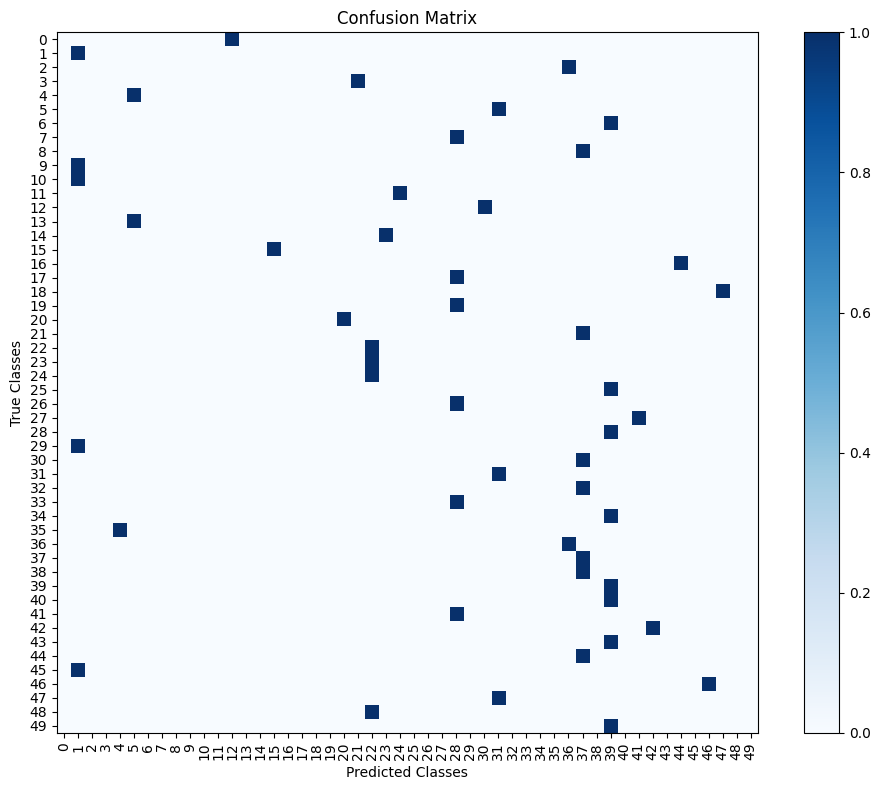

In [26]:
from sklearn import   metrics

def show_confusion_matrix_v1(all_labels, all_predictions):
  print("Confusion matrix:\n")
  cmatrix = metrics.confusion_matrix(all_labels, all_predictions)
  for  i,r in enumerate(cmatrix):
    if i==0:
      line = ''.ljust(5)
      for user in range(0,len(r)):
        line += str(user).ljust(3)
      print( line)

    line = str(i).ljust(5)
    for c in r:
      if c<1:
        c= ' '.ljust(3)
      line += str(c).ljust(3)
    print( line)

def show_confusion_matrix(all_labels, all_predictions, num_classes):
  cmatrix = metrics.confusion_matrix(all_labels, all_predictions)

  cmap = plt.cm.get_cmap('Blues')
  plt.figure(figsize=(10, 8))
  plt.imshow(cmatrix, cmap=cmap)

  cbar = plt.colorbar()


  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Classes')
  plt.ylabel('True Classes')
  plt.xticks(range(num_classes), rotation=90)
  plt.yticks(range(num_classes))

  plt.tight_layout()
  plt.show()





model_options.max_sequence_length = 30
model_options.batch_size = 10


td = TesingData()
td.load_test_lines('bonus-testing_strips.pkl')
print(td.testing_data.keys())

model = load_model(MODEL_CHECKPOINT_PATH+'sequence-classifier-model-08-0.30.hdf5')
model.summary()

input_shape = (model_options.image_height, model_options.image_width)
testing_gen = td.batch_generator(max_batch_size=model_options.max_sequence_length,  max_sequence_length=model_options.max_sequence_length, target_size=input_shape)

all_predictions, all_labels = [], []
batch_x = []
for b, (batch_x, labels) in enumerate(testing_gen):
    predict_values = model.predict(batch_x)
    all_labels += np.argmax(labels, axis=1).tolist()
    all_predictions += np.argmax(predict_values, axis=1).tolist()

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
accuracy = sum(all_predictions == all_labels) / len(all_labels)
print(f"Accuracy: {accuracy:.4f}")

print("Logistic regression using  features cross validation:\n%s\n" % (metrics.classification_report(all_labels,all_predictions)))

show_confusion_matrix(all_labels, all_predictions, 50)

In [20]:
k = []
for i , pred in enumerate(all_predictions):
  if all_predictions[i]==all_labels[i]:
    k.append(all_labels[i])
good = set(k)
print(good)
print(len(good))

{1, 34, 35, 36, 37, 38, 39, 42, 43, 46, 15, 18, 20, 22, 31}
15


In [25]:
td.testing_data.keys()

dict_keys([204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253])

In [22]:
td = TesingData()
td.load_test_lines('testing_strips.pkl')
print(td.testing_data.keys())



for i , pred in enumerate(all_predictions):
  if all_predictions[i] != all_labels[i]:
    predicted = all_predictions[i]
    label =  all_labels[i]
    print(f"{predicted} - {label}" )
    show_line(td.testing_data[predicted]]['line'])
    show_line(td.testing_data[label]['line'])
  if i == 30:
    break



2 - 0


KeyError: ignored

<Figure size 640x480 with 0 Axes>

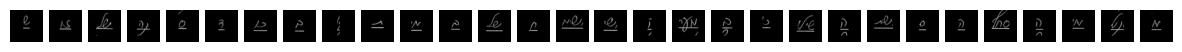

<Figure size 640x480 with 0 Axes>

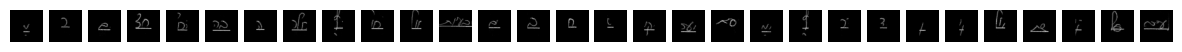

<Figure size 640x480 with 0 Axes>

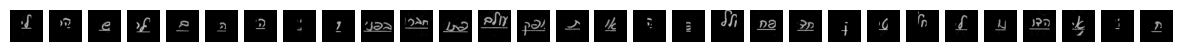

<Figure size 640x480 with 0 Axes>

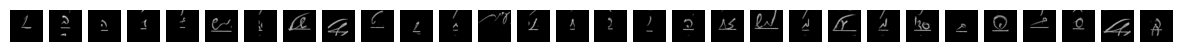

<Figure size 640x480 with 0 Axes>

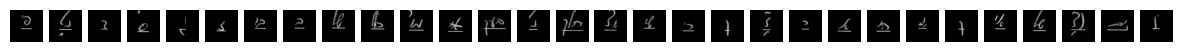

<Figure size 640x480 with 0 Axes>

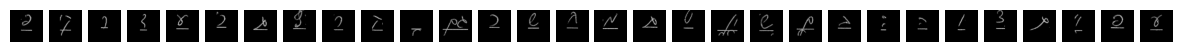

<Figure size 640x480 with 0 Axes>

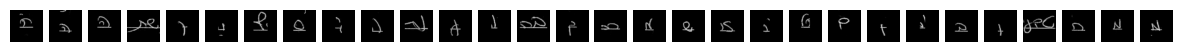

<Figure size 640x480 with 0 Axes>

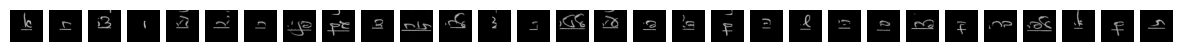

<Figure size 640x480 with 0 Axes>

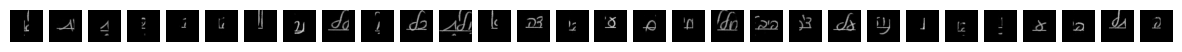

<Figure size 640x480 with 0 Axes>

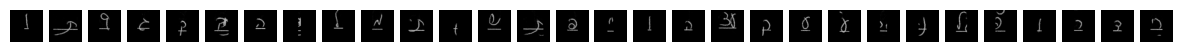

In [ ]:

td = TesingData()
td.load_test_lines('testing_strips.pkl')

input_shape = (model_options.image_height, model_options.image_width)
testing_gen = td.line_generator( max_sequence_length=model_options.max_sequence_length, target_size=input_shape)
i=0
for  label, sequence in testing_gen:
  show_strip(sequence)
  i+=1
  if i==10:
    break




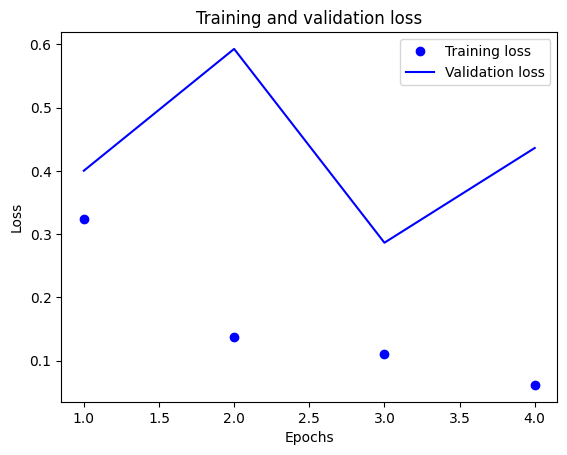

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc  = history_dict['accuracy']
epochs = range(1, len(acc) + 1)
plt.clf()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

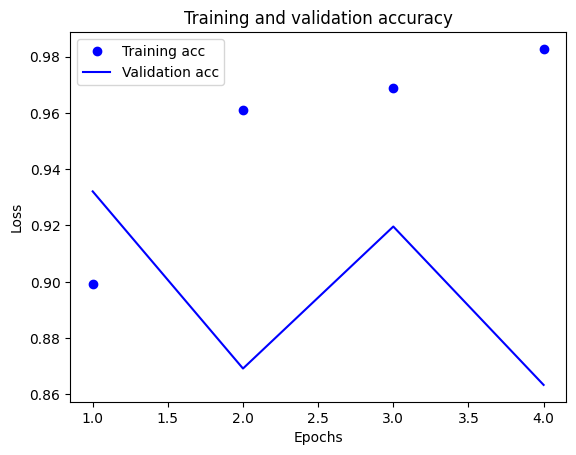

In [ ]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()